# Quantum machine learning in Amazon Braket Hybrid Jobs

This notebook demonstrates a typical quantum machine learning workflow, including uploading data, monitoring training, and tuning hyperparameters. We focus on training a parameterized quantum circuit for an unsupervised generative modelling task.


## Learning outcomes

* Set input data 
* Set hyperparameters 
* Submit multiple hybrid jobs asynchronously 
* Monitor hybrid job progress via the AWS Console 
* Download and plot results

## Background: Generative modelling 

Generative modelling is an unsupervised learning task where the goal is to generate new synthetic samples from an unknown target probability distribution. We denote the target probability distribution as $p(x)$, and the estimated distribution as $p_{\theta}(x)$. The goal is to learn $p_{\theta}(x)$ that closely resembles the target $p(x)$.  One metric to quantify the difference between probability distributions is the maximum mean discrepancy (MMD) loss . 

$$MMD(x, y) = \sum_{j=1}^N \sum_{j'=1}^N k(y_j, y_{j'}) + \sum_{i=1}^N \sum_{i'=1}^N k(x_i, x_{i'})  - 2 \sum_{j=1}^N \sum_{i=1}^N k(y_j, x_i)$$
where $x$ is a sample from the target data $p(x)$, $y$ is a sample from the generative model $p_{\theta}(x)$, and $k$ is a Gaussian kernel

$$ k(x,y)= \sum_{\sigma} e^{-(x-y)^2/(2 \sigma^2))}$$

The MMD loss is zero if and only if $p(x)=p_{\theta}(x)$ for all $x$. 

Learning a good approximation $p_{\theta}$ depends on the expressibility of the model, the effectiveness of the training algorithm, and the ability to sample the circuit efficiently. 


## Quantum Circuit Born Machine 

Quantum circuits are a natural fit for generative modelling because they are inherently probabilistic; the wavefunction encodes a probability according to the Born rule:

$$p(x)=|\langle x|\psi\rangle|^2$$

In quantum mechanics, we do not have access to $p(x)$ directly, but we can efficiently sample using projective measurements [1]. This is an implicit generative model similar to generative adversarial networks (GANs). Quantum circuits allow fast sampling from a high-dimension distribution, and have large expressive power. 

The QCBM in this tutorial consists of alternating layers of single qubit rotations ($RX, RZ, RX$), followed by an entangling layer of CNot gates on each neighboring qubits. The final measurement layer computes the bit string samples of each outcome. Run the cell below to print a circuit diagram of a QCBM with randomly initialized parameters.


In [1]:
import numpy as np

from braket.devices import LocalSimulator
from qcbm.qcbm import QCBM


n_qubits = 3
n_layers = 2

init_params = np.random.rand(3 * n_layers * n_qubits)
device = LocalSimulator()
qcbm = QCBM(device, n_qubits, n_layers, np.random.rand(1))
print(qcbm.create_circuit(init_params))

T  : |   0    |   1    |   2    |3|4|    5     |   6    |   7    |   8    |9|10|11|Result Types|
                                                                                                
q0 : -Rx(0.31)-Rz(0.59)-Rx(0.45)-C---X----------Rx(0.16)-Rz(0.16)-Rx(0.01)-C----X--Probability--
                                 |   |                                     |    |  |            
q1 : -Rx(0.08)-Rz(0.44)-Rx(0.74)-X-C-|-Rx(0.36)-Rz(0.49)-Rx(0.96)----------X-C--|--Probability--
                                   | |                                       |  |  |            
q2 : -Rx(0.30)-Rz(0.60)-Rx(0.46)---X-C----------Rx(0.98)-Rz(0.16)-Rx(0.75)---X--C--Probability--

T  : |   0    |   1    |   2    |3|4|    5     |   6    |   7    |   8    |9|10|11|Result Types|


## Problem setup

This notebook demonstrates training a QCBM on a toy data set using Amazon Braket Hybrid Jobs. The code for the QCBM is in `qcbm` directory. The `qcbm_job.py` contains the code that will run when we create a Braket Hybrid Job. The other file (`qcbm.py`) contain the source code for the QCBM. 

In this tutorial, we use a small number of qubits to make it quick to test the algorithm. We use the on-demand simulator SV1 to run our circuits and gradient calculations in parallel (up to 35 concurrent tasks).  

We first set the number of qubits we want to use in our problem:

In [2]:
n_qubits = 5

## Generate data

As an example, we consider the toy example of learning a mixture of Gaussian distributions. We set a numpy random seed to produce the same data each time, but try experimenting with the number of peaks and number of qubits to produce harder or easier data sets. For this example, the target distribution $p(x)$ is a Gaussian on 5 bits (so $2^5$ possible values), with peaks at $\mu_1=7$ and $\mu_2=20$, with standard deviations $\sigma_1=1$, $\sigma_2 = 2$. We generate and plot the data as a probability density function in the cell below.

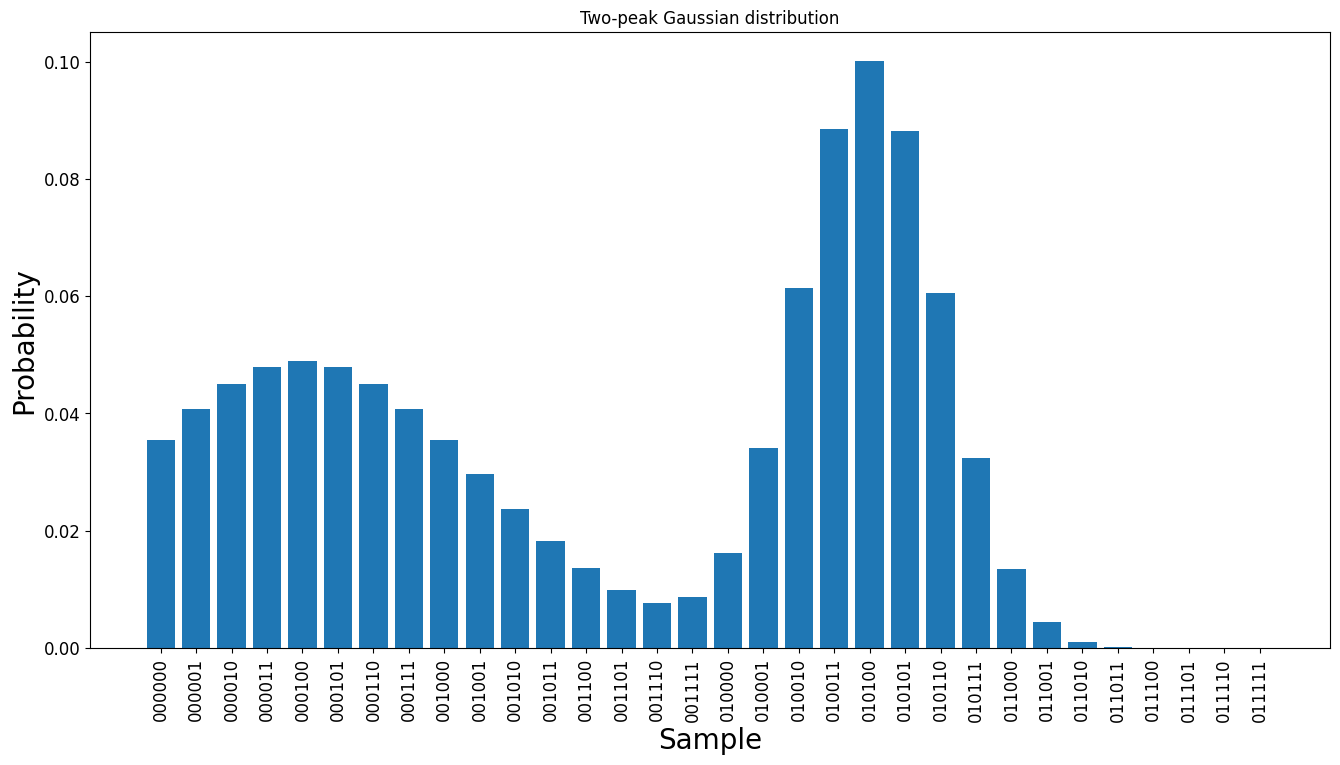

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

def gaussian(n_qubits, mu, sigma=1):
    x = np.arange(2 ** n_qubits)
    gaussian = (
        1.0
        / np.sqrt(2 * np.pi * sigma ** 2)
        * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    )
    return gaussian / sum(gaussian)


data = gaussian(n_qubits, mu=4, sigma=5) + gaussian(n_qubits, mu=20, sigma=2)
data = data / sum(data)


labels = ["{0:{fill}6b}".format(i, fill='0') for i in range(len(data))]

plt.bar(range(2 ** n_qubits), data)
plt.xticks([i for i in range(len(data))], labels, rotation='vertical', size=12)
plt.yticks(size=12)

plt.xlabel("Sample", size=20)
plt.ylabel("Probability", size=20)
plt.title("Two-peak Gaussian distribution")

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.show()

In [4]:
np.save("data.npy", data) # save data to file

# Upload data

To run our algorithm as a Hybrid Job, we need to input the data to the job. There are two primary ways to pass data to a Braket Hybrid Job.

1. Firstly, we could pass the name of a local file as a string. In this example, it would be "data.npy". In the algorithm script (`qcbm_job.py`), we would then load the file with `f"{input_dir}/input/data.npy"` since `"input"` is the default S3 channel used by Braket Hybrid Jobs. We create the hybrid job with 

```
        AwsQuantumJob(input_data="data.npy",...)
```


2. Secondly, we could directly upload the data to S3 and point the hybrid job to that bucket. In the cell below, we provide a utility function that uploads the data to S3 with the name `filename` under the directory `dir_name` in the default bucket. Optionally, we can pass a specific AwsSession to customize where the data is saved. The S3 path would be passed to create a hybrid job similarly:

```
        AwsQuantumJob(input_data=s3_path,...)
```



In [5]:
# Upload dataset to S3
from braket.aws import AwsSession

def setup_input_stream(data, filename, dir_name="job-data", aws_session=AwsSession()):
    stream_s3_uri = aws_session.construct_s3_uri(aws_session.default_bucket(), dir_name)
    np.save(filename, data)
    path = f"{stream_s3_uri}/" + filename
    aws_session.upload_to_s3(filename, path)
    return path

In [6]:
s3_path = setup_input_stream(data, "data.npy")
print(s3_path)

s3://amazon-braket-us-west-1-961591465522/job-data/data.npy


As a double check, try navigating to this S3 bucket using the AWS Console to verify the data was successfully uploaded.

## Training  

Next, we set the hyperparameters for our training hybrid job. To keep it simple, we only consider the following hyperparameters: number of qubits `n_qubits`, number of layers in the QCBM `n_layers`, and the number of iterations in the optimization algorithm.

The number of layers determines how many parameters are in the quantum circuit. For the QCBM, we need `n_params = 3 * n_layers * n_qubits`.


In [7]:
from braket.tracking import Tracker
from scipy.optimize import minimize

from braket.jobs import get_results_dir
from braket.jobs.metrics import log_metric

from qcbm.qcbm import mmd_loss

def train_circuit(n_qubits, n_layers, n_iterations=10):

    cost_tracker = Tracker().start()

    global iteration_number # for scipy optimizer callbacks
    iteration_number = 0

    data = np.load("data.npy")
    
    qcbm = QCBM(device, n_qubits, n_layers, data)
    
    init_params = np.random.rand(3 * n_layers * n_qubits)

    def callback(x):
        global iteration_number  # global
        iteration_number += 1
        loss = mmd_loss(qcbm.probabilities(x), data)
        log_metric(
            metric_name="loss",
            value=loss,
            iteration_number=iteration_number,
        )

    res = minimize(
        lambda x: mmd_loss(qcbm.probabilities(x), data),
        x0=init_params,
        method="L-BFGS-B",
        jac=lambda x: qcbm.gradient(x),
        options={"maxiter": n_iterations},
        callback=callback,
    )
    final_params = res.x

    # save final params to a file
    np.save(get_results_dir() + "/final_params.npy", final_params)
    
    return {
            "params": final_params,
            "task summary": cost_tracker.quantum_tasks_statistics(),
            "estimated cost": float(cost_tracker.qpu_tasks_cost() + cost_tracker.simulator_tasks_cost()),
        }


Now let's run the function to verify that it works as expected.

In [8]:
%%time

train_circuit(n_qubits, n_layers=n_layers, n_iterations=5)

Metrics - timestamp=1696980538.6374562; loss=0.1117307884668797; iteration_number=1;
Metrics - timestamp=1696980540.8189466; loss=0.08828288927814171; iteration_number=2;
Metrics - timestamp=1696980543.0087247; loss=0.07543981431860936; iteration_number=3;
Metrics - timestamp=1696980545.143632; loss=0.06218799492616833; iteration_number=4;
Metrics - timestamp=1696980547.4727094; loss=0.04789346174363429; iteration_number=5;
CPU times: user 3.58 s, sys: 535 ms, total: 4.12 s
Wall time: 13.2 s


{'params': array([-0.3451717 ,  0.09040996, -0.02901952,  0.31208388,  0.25883415,
         1.14804756,  0.24204576,  1.22631648, -0.49480087, -0.48808554,
         0.30654297,  0.5375834 ,  0.2822961 ,  1.0865759 ,  0.27409942,
         0.52203709, -0.03611859, -0.17707525,  0.42666373,  0.32012481,
        -0.39666703,  0.6761503 ,  0.61435699,  0.84460115,  0.41000909,
         0.95579112,  0.99867887,  0.51158326,  0.67875134,  0.87597162]),
 'task summary': {},
 'estimated cost': 0.0}

Now we show how to run on AWS! 

In [9]:
from braket.jobs import hybrid_job

# Now run the job on AWS ! 
# For now, lets set local=True. This uses a local Docker container
@hybrid_job(device=None, local=True, include_modules="qcbm", input_data="data.npy")
def train_circuit_hybrid_job(n_qubits, n_layers, n_iterations):
    return train_circuit(n_qubits, n_layers, n_iterations)

In [10]:
%%time 

job = train_circuit_hybrid_job(n_qubits, n_layers=n_layers, n_iterations=10)
res = job.result()

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/drbeach/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Pulling docker container image. This may take a while.


Login Succeeded
latest: Pulling from amazon-braket-base-jobs
Digest: sha256:b0ef7f68bbe4d55aadff8d5836d4d9f0e82b496c65d8d3756735f44f9626d48d
Status: Image is up to date for 292282985366.dkr.ecr.us-west-1.amazonaws.com/amazon-braket-base-jobs:latest
292282985366.dkr.ecr.us-west-1.amazonaws.com/amazon-braket-base-jobs:latest


Using the short-lived AWS credentials found in session. They might expire while running.


Boto3 Version:  1.28.53
Beginning Setup
Checking for Additional Requirements
Additional Requirements Check Finished
Running Code As Process
data.npy -> /opt/braket/input/data/input/data.npy
Metrics - timestamp=1696980560.61209; loss=0.07289319653524645; iteration_number=1;
Metrics - timestamp=1696980563.0291822; loss=0.05597856115420746; iteration_number=2;
Metrics - timestamp=1696980565.3658035; loss=0.04344716737961207; iteration_number=3;
Metrics - timestamp=1696980567.7164202; loss=0.037212911886899125; iteration_number=4;
Metrics - timestamp=1696980570.1240056; loss=0.02874363099053412; iteration_number=5;
Metrics - timestamp=1696980572.5346081; loss=0.021889939112021528; iteration_number=6;
Metrics - timestamp=1696980574.8872745; loss=0.015492825236110841; iteration_number=7;
Metrics - timestamp=1696980577.2872455; loss=0.013127603473105431; iteration_number=8;
Metrics - timestamp=1696980579.649192; loss=0.013848496962480417; iteration_number=9;
Metrics - timestamp=1696980581.997

We are now prepared to run a fully-managed Hybrid Job to keep track of our experiments and scale up to larger models. 


Great! We created our first quantum machine learning job! 

Since we set `wait_until_complete=False`, the hybrid job will run asynchronously and silently. We can check the status of the hybrid job with 

In [11]:
job.state()

'COMPLETED'

We can also monitor the status of the hybrid job with the AWS Console.

<div align="center"><img src="console_figures/running_job.png"/></div>

Once it’s complete, we can grab the result with `job.result()` which will wait for the hybrid job to finish. In `qcbm_job.py`, we set the results to be the final parameters of the QCBM that minimized the loss function. Results are returned as a dictionary.

In [12]:
%%time 
job.result()

CPU times: user 899 µs, sys: 283 µs, total: 1.18 ms
Wall time: 811 µs


{'params': array([ 1.23662401,  0.09048983,  0.63888342,  0.13211417,  0.11193414,
         0.27924854,  0.94420927,  0.22417977,  0.44849226,  0.49440225,
         0.79755362,  0.19541365,  0.15304238,  0.08769421,  0.27826722,
         1.6823281 ,  1.06199946, -0.45008153,  0.98444135,  0.43670053,
        -0.11265109, -0.25626846,  0.88598834, -0.0817903 ,  1.20265655,
         1.03380836,  0.75718957,  0.57374637,  0.5243578 ,  0.77827011]),
 'task summary': {},
 'estimated cost': 0.0}

Awesome! Our first quantum machine learning job finished! Now let’s look at the training metrics.

## Metrics and plotting

In the `qcbm_job.py` script, we monitored the loss function during training with 
```
log_metric(
    metric_name="loss",
    value=loss,
    iteration_number=iteration_number,
)
```
Metrics recorded in this way are visible from the "Monitor" tab in the AWS Console. It will look similar to the below image:

<div align="center"><img src="console_figures/metrics.png"/></div>

Metrics are also available by calling `job.metrics()`. Using pandas, and matplotlib, we plot the convergence of the loss below. 

<Axes: xlabel='iteration_number'>

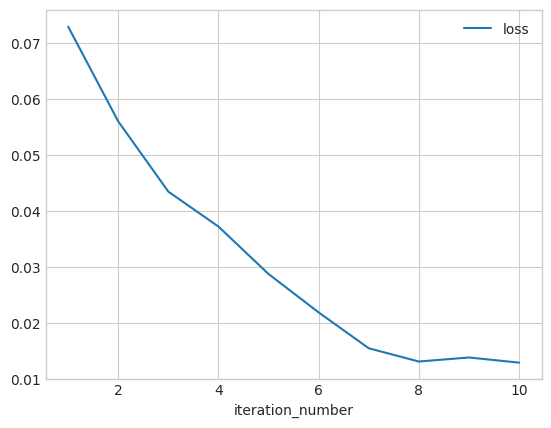

In [13]:
# Plotting the convergence of the loss function metric
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use("seaborn-v0_8-whitegrid")


df = pd.DataFrame(job.metrics())
df.sort_values(by=["iteration_number"]).plot(x="iteration_number", y="loss")

In `qcbm_job.py`, we called `save_job_result({"params": params.tolist()})
` to save the optimal parameters that minimized the loss function.
Importantly, we can plot the predicted probability distribution vs the target probability from the data. To do so, we first import the QCBM locally again, but now we initialize it with the parameters returned from our hybrid job.

In [14]:
job.result()["params"]

array([ 1.23662401,  0.09048983,  0.63888342,  0.13211417,  0.11193414,
        0.27924854,  0.94420927,  0.22417977,  0.44849226,  0.49440225,
        0.79755362,  0.19541365,  0.15304238,  0.08769421,  0.27826722,
        1.6823281 ,  1.06199946, -0.45008153,  0.98444135,  0.43670053,
       -0.11265109, -0.25626846,  0.88598834, -0.0817903 ,  1.20265655,
        1.03380836,  0.75718957,  0.57374637,  0.5243578 ,  0.77827011])

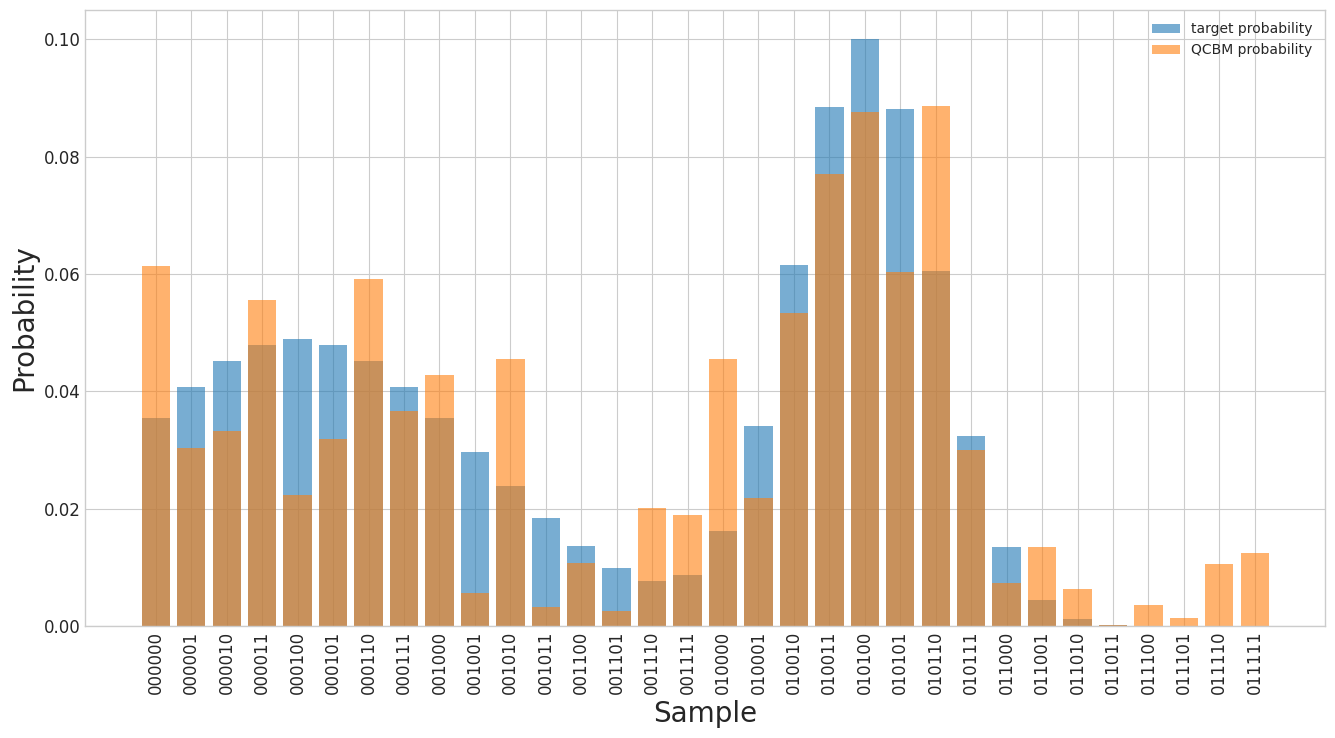

In [15]:
# Plotting the original probability distribution, and the QCBM prediction probability
from braket.devices import LocalSimulator
from qcbm.qcbm import QCBM

device = LocalSimulator()
qcbm = QCBM(device, n_qubits, n_layers=n_layers, data=data)

qcbm_probs = qcbm.probabilities(job.result()["params"])

labels = ["{0:{fill}6b}".format(i, fill='0') for i in range(len(data))]

plt.bar(range(2 ** n_qubits), data, label="target probability", alpha=0.6)
plt.bar(range(2 ** n_qubits), qcbm_probs, label="QCBM probability", alpha=0.6)
plt.xticks([i for i in range(len(data))], labels, rotation='vertical', size=12)
plt.yticks(size=12)

plt.xlabel("Sample", size=20)
plt.ylabel("Probability", size=20)

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.legend()
plt.show()

Great! As expected, the QCBM probability distribution closes matches the target distribution. 

In [16]:
print("Quantum Task Summary")
print(job.result()['task summary'])
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run quantum tasks in this hybrid job: {job.result()['estimated cost']} USD")

Quantum Task Summary
{}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run quantum tasks in this hybrid job: 0.0 USD


## Running different hyperparameters

One of the strengths of Braket Hybrid Jobs is the ability to submit and monitor many hybrid jobs simultaneously. We can use this to perform a grid search to find good hyperparameters. Below we initialize 4 unique hybrid jobs with different `n_layers`.

In [21]:
jobs = []

for n_layers in range(1, 5):
    print(f"Creating job with {n_layers} layers")
    tmp_job = train_circuit_hybrid_job(n_qubits, n_layers, n_iterations=10)

    jobs.append(tmp_job)

Creating job with 1 layers


WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/drbeach/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Pulling docker container image. This may take a while.


Login Succeeded
latest: Pulling from amazon-braket-base-jobs
Digest: sha256:b0ef7f68bbe4d55aadff8d5836d4d9f0e82b496c65d8d3756735f44f9626d48d
Status: Image is up to date for 292282985366.dkr.ecr.us-west-1.amazonaws.com/amazon-braket-base-jobs:latest
292282985366.dkr.ecr.us-west-1.amazonaws.com/amazon-braket-base-jobs:latest


Using the short-lived AWS credentials found in session. They might expire while running.


Boto3 Version:  1.28.53
Beginning Setup
Checking for Additional Requirements
Additional Requirements Check Finished
Running Code As Process
data.npy -> /opt/braket/input/data/input/data.npy
Metrics - timestamp=1696980706.0255969; loss=0.1320824973926731; iteration_number=1;
Metrics - timestamp=1696980707.1785936; loss=0.07398631877019046; iteration_number=2;
Metrics - timestamp=1696980708.4048908; loss=0.0686673987944803; iteration_number=3;
Metrics - timestamp=1696980709.5750618; loss=0.06759261954376344; iteration_number=4;
Metrics - timestamp=1696980710.8294325; loss=0.06591962725646394; iteration_number=5;
Metrics - timestamp=1696980711.971933; loss=0.060954599766437745; iteration_number=6;
Metrics - timestamp=1696980713.2593057; loss=0.05984452470222795; iteration_number=7;
Metrics - timestamp=1696980714.4932675; loss=0.05659717393178432; iteration_number=8;
Metrics - timestamp=1696980715.6758966; loss=0.057920791514232184; iteration_number=9;
Metrics - timestamp=1696980721.246387

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/drbeach/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Pulling docker container image. This may take a while.


Login Succeeded
latest: Pulling from amazon-braket-base-jobs
Digest: sha256:b0ef7f68bbe4d55aadff8d5836d4d9f0e82b496c65d8d3756735f44f9626d48d
Status: Image is up to date for 292282985366.dkr.ecr.us-west-1.amazonaws.com/amazon-braket-base-jobs:latest
292282985366.dkr.ecr.us-west-1.amazonaws.com/amazon-braket-base-jobs:latest


Using the short-lived AWS credentials found in session. They might expire while running.


Boto3 Version:  1.28.53
Beginning Setup
Checking for Additional Requirements
Additional Requirements Check Finished
Running Code As Process
data.npy -> /opt/braket/input/data/input/data.npy
Metrics - timestamp=1696980744.795449; loss=0.0920526024350733; iteration_number=1;
Metrics - timestamp=1696980747.1839106; loss=0.079270243900888; iteration_number=2;
Metrics - timestamp=1696980749.5142465; loss=0.075047467945516; iteration_number=3;
Metrics - timestamp=1696980751.8504496; loss=0.05403498027293485; iteration_number=4;
Metrics - timestamp=1696980754.1794422; loss=0.03916801171862294; iteration_number=5;
Metrics - timestamp=1696980758.8430383; loss=0.030441939679059227; iteration_number=6;
Metrics - timestamp=1696980761.1445017; loss=0.0250653918787877; iteration_number=7;
Metrics - timestamp=1696980765.8421276; loss=0.020570041831696972; iteration_number=8;
Metrics - timestamp=1696980768.2450395; loss=0.018823520879387323; iteration_number=9;
Metrics - timestamp=1696980770.6775749; 

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/drbeach/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Pulling docker container image. This may take a while.


Login Succeeded
latest: Pulling from amazon-braket-base-jobs
Digest: sha256:b0ef7f68bbe4d55aadff8d5836d4d9f0e82b496c65d8d3756735f44f9626d48d
Status: Image is up to date for 292282985366.dkr.ecr.us-west-1.amazonaws.com/amazon-braket-base-jobs:latest
292282985366.dkr.ecr.us-west-1.amazonaws.com/amazon-braket-base-jobs:latest


Using the short-lived AWS credentials found in session. They might expire while running.


Boto3 Version:  1.28.53
Beginning Setup
Checking for Additional Requirements
Additional Requirements Check Finished
Running Code As Process
data.npy -> /opt/braket/input/data/input/data.npy
Metrics - timestamp=1696980797.2029157; loss=0.06973944706928387; iteration_number=1;
Metrics - timestamp=1696980801.0008664; loss=0.0378010271477478; iteration_number=2;
Metrics - timestamp=1696980804.7025132; loss=0.031451809041319945; iteration_number=3;
Metrics - timestamp=1696980808.5395622; loss=0.02382796545032906; iteration_number=4;
Metrics - timestamp=1696980812.2040646; loss=0.020022737972091142; iteration_number=5;
Metrics - timestamp=1696980819.6141663; loss=0.017016553383759403; iteration_number=6;
Metrics - timestamp=1696980823.473824; loss=0.014516448248638347; iteration_number=7;
Metrics - timestamp=1696980827.3185594; loss=0.013476080716761207; iteration_number=8;
Metrics - timestamp=1696980831.0293283; loss=0.009235945517386712; iteration_number=9;
Metrics - timestamp=1696980834.7

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/drbeach/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Pulling docker container image. This may take a while.


Login Succeeded
latest: Pulling from amazon-braket-base-jobs
Digest: sha256:b0ef7f68bbe4d55aadff8d5836d4d9f0e82b496c65d8d3756735f44f9626d48d
Status: Image is up to date for 292282985366.dkr.ecr.us-west-1.amazonaws.com/amazon-braket-base-jobs:latest
292282985366.dkr.ecr.us-west-1.amazonaws.com/amazon-braket-base-jobs:latest


Using the short-lived AWS credentials found in session. They might expire while running.


Boto3 Version:  1.28.53
Beginning Setup
Checking for Additional Requirements
Additional Requirements Check Finished
Running Code As Process
data.npy -> /opt/braket/input/data/input/data.npy
Metrics - timestamp=1696980864.663; loss=0.06258963088089009; iteration_number=1;
Metrics - timestamp=1696980869.951069; loss=0.039422657253531945; iteration_number=2;
Metrics - timestamp=1696980875.255252; loss=0.030442119579086213; iteration_number=3;
Metrics - timestamp=1696980880.5681646; loss=0.018622147938571254; iteration_number=4;
Metrics - timestamp=1696980886.0710597; loss=0.013024654365561272; iteration_number=5;
Metrics - timestamp=1696980891.7490792; loss=0.009717443512849422; iteration_number=6;
Metrics - timestamp=1696980897.186511; loss=0.00842614171397793; iteration_number=7;
Metrics - timestamp=1696980902.8316388; loss=0.005896536247535833; iteration_number=8;
Metrics - timestamp=1696980913.6627789; loss=0.005940537041906668; iteration_number=9;
Metrics - timestamp=1696980918.98103

To check the results, we could load the results as we did before, or we could check the "Monitor" tab in the Braket Jobs dashboard in the AWS Console.

<!-- <div align="center"><img src="console_figures/hp_job_console.png"/></div> -->

In [22]:
%%time 
jobs[-1].result(); # wait for the last job to finish

CPU times: user 0 ns, sys: 1.44 ms, total: 1.44 ms
Wall time: 1.02 ms


We can also load the hybrid jobs directly from their hybrid job arns. 

We can now plot the results from all the hyperparameters experiments once they finish. If the cell below does not work, wait a few minutes for metrics to load and try again.

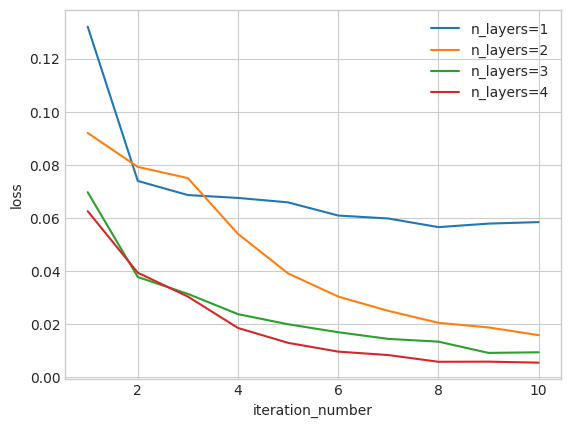

In [23]:
dfs = []
for i, j in enumerate(jobs):
    df = pd.DataFrame(j.metrics())
    df.sort_values(by=["iteration_number"])
    dfs.append(df)
    plt.plot(df["iteration_number"], df["loss"], label=f"n_layers={i+1}")

plt.xlabel("iteration_number")
plt.ylabel("loss")
plt.legend()
plt.show()

For the plots above, we see that the loss is much lower for `n_layers=3` and `n_layers=4`. We can conclude for 5 qubits, we need at least 3 layers in the QCBM to accurately learn the two-peak Gaussian data. 

In [24]:
for job in jobs:
    print("Quantum Task Summary")
    print(job.result()['task summary'])
    print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
    print(f"Estimated cost to run quantum tasks in this hybrid job: {job.result()['estimated cost']} USD")

Quantum Task Summary
{}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run quantum tasks in this hybrid job: 0.0 USD
Quantum Task Summary
{}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run quantum tasks in this hybrid job: 0.0 USD
Quantum Task Summary
{}
Note: Charges shown are estimates based on your Amazon Braket 

## Conclusion 

In this notebook, we submitted a single training hybrid job in Amazon Braket Hybrid Jobs. We then simultaneously submitted 4 new hybrid jobs with different hyperparameters to learn about the number of layers required in our circuit.

## References


[1] Benedetti, Marcello, Delfina Garcia-Pintos, Oscar Perdomo, Vicente Leyton-Ortega, Yunseong Nam, and Alejandro Perdomo-Ortiz. “A Generative Modeling Approach for Benchmarking and Training Shallow Quantum Circuits.” Npj Quantum Information 5, no. 1 (May 27, 2019): 1–9. https://doi.org/10.1038/s41534-019-0157-8.

[2] Liu, Jin-Guo, and Lei Wang. “Differentiable Learning of Quantum Circuit Born Machine.” Physical Review A 98, no. 6 (December 19, 2018): 062324. https://doi.org/10.1103/PhysRevA.98.062324.
